# Online Selection of HLS Representations

In [1]:
from lrcb.bandits.multirep_finite import FiniteMultiBandit
from lrcb.representations.finite_representations import make_random_rep, hls_rank, rank, derank_hls, make_hls_rank
from lrcb.representations.finite_representations import is_cmb, is_hls, spans, hls_lambda, derank_cmb, LinearRepresentation
from lrcb.algos.oful import oful
from lrcb.algos.lr_oful import select_oful
from lrcb.algos.maximin_oful import maximin_oful
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lrcb.visualization.notebook_utils as nu
from jupyterthemes import jtplot
#jtplot.style()
plt.rcParams['figure.figsize'] = [12, 9]

## Common settings

In [2]:
nc = 20
na = 4
dim = 5
noise = 0.1
seeds = range(5)

Generate original HLS representation

In [3]:
"""
r0 = make_random_rep(nc, na, dim, normalize=True)
np.save('basic_features', r0.features)
np.save('basic_param', r0._param)
"""
r0 = LinearRepresentation(np.load('../logs/basic_features.npy'), np.load('../logs/basic_param.npy'))
#"""
assert is_hls(r0)

OFUL settings

In [4]:
iterations = 10000
reg = 1
delta = 0.01
param_bound = 1. #Guaranteed by make_random_rep(..., normalize=True)

## CMB, destructive approach (different parameter) (t)

Re-use the same original HLS representation

Generate non-HLS **equivalent** representations with varying HLS rank **and different parameters**

In [5]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.feat_bound(), r.feat_bound(reduce=np.min)))
print('%d/%d %s %f %f' % (hls_rank(reps[-1]), rank(reps[-1]), '(CMB)' if is_cmb(r) else '', reps[-1].opt_feat_bound(), reps[-1].opt_feat_bound(reduce=np.min)))

#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/5 (CMB) 5.218460 0.026303
2/5 (CMB) 5.218460 0.026613
3/5 (CMB) 5.218460 0.027249
4/5 (CMB) 5.218460 0.026982
5/5 (CMB) 5.637567 1.690230


Regret of OFUL with different representations

In [6]:
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(t)' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

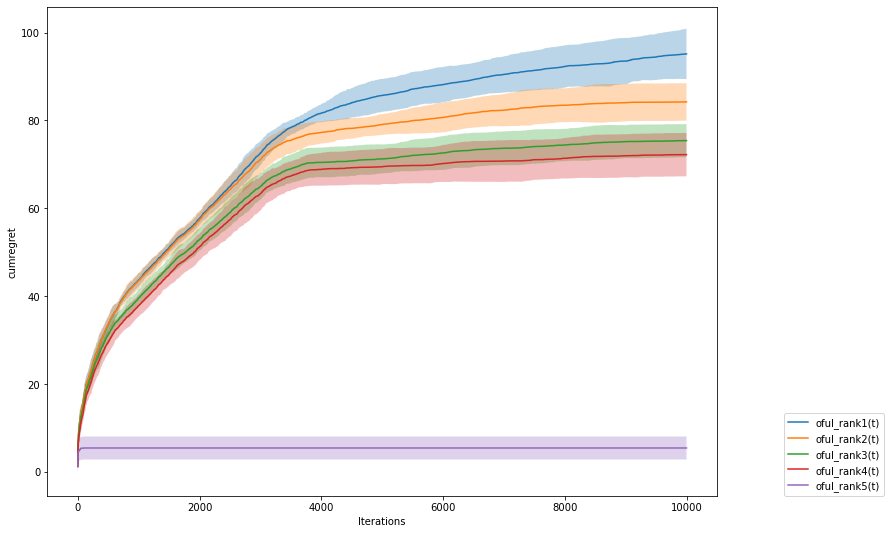

In [7]:
names = ['oful_rank%d(t)' % d for d in range(1, dim+1)]
nu.compare('../logs', names, 'cumregret', seeds)

(Final) cumulated regret is (almost) sorted by hls rank, with the HLS representation having a large advantage

In [8]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank5(t)', 5.41316214084099),
 ('oful_rank4(t)', 72.20348542761836),
 ('oful_rank3(t)', 75.40328098117108),
 ('oful_rank2(t)', 84.21840278579698),
 ('oful_rank1(t)', 95.14088972804696)]

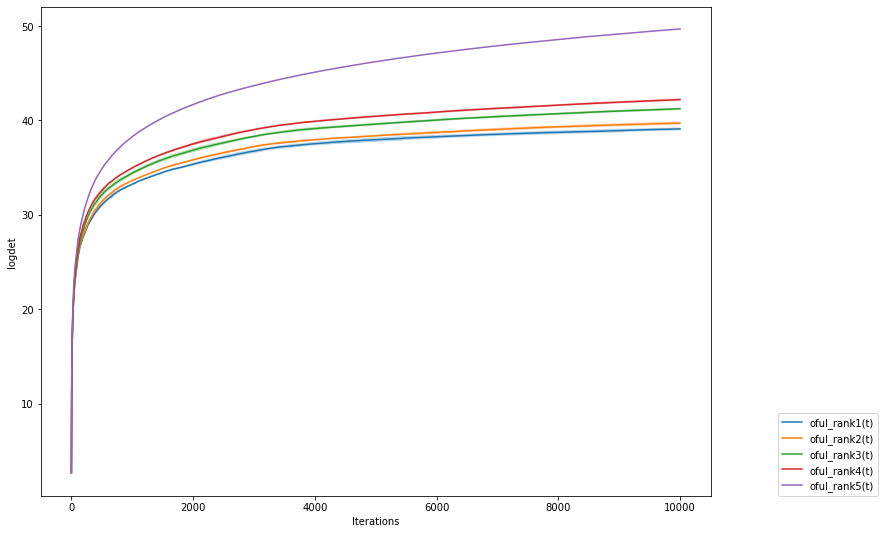

In [9]:
nu.compare('../logs', names, 'logdet', seeds)

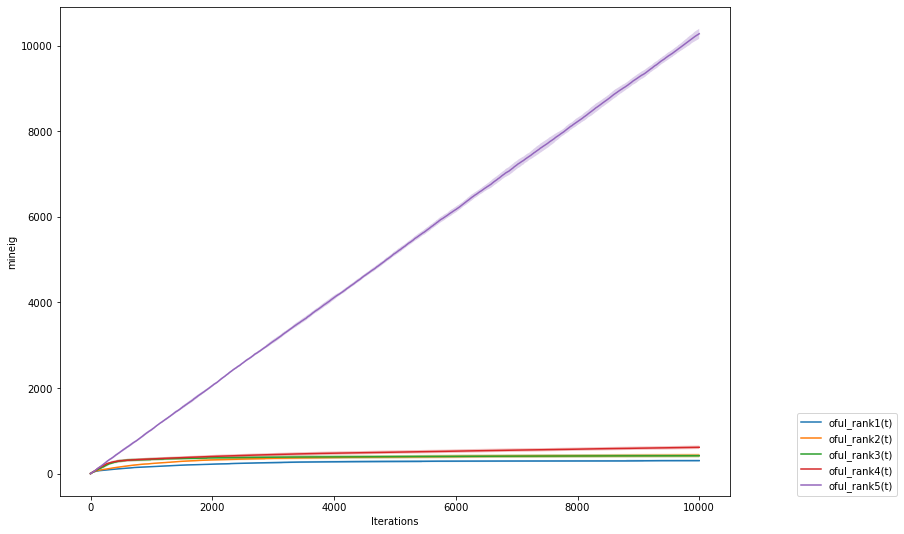

In [10]:
nu.compare('../logs', names, 'mineig', seeds)

Regret of model-selection algorithm compared to best model

In [11]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, 
                rule='maxlambdamin',
                seed=seed, verbose=False, logname='oful_select(t)')

In [12]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, 
                rule='minbonus',
                seed=seed, verbose=False, logname='oful_meta(t)')

In [13]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound,
                seed=seed, verbose=False, logname='oful_maximin(t)')

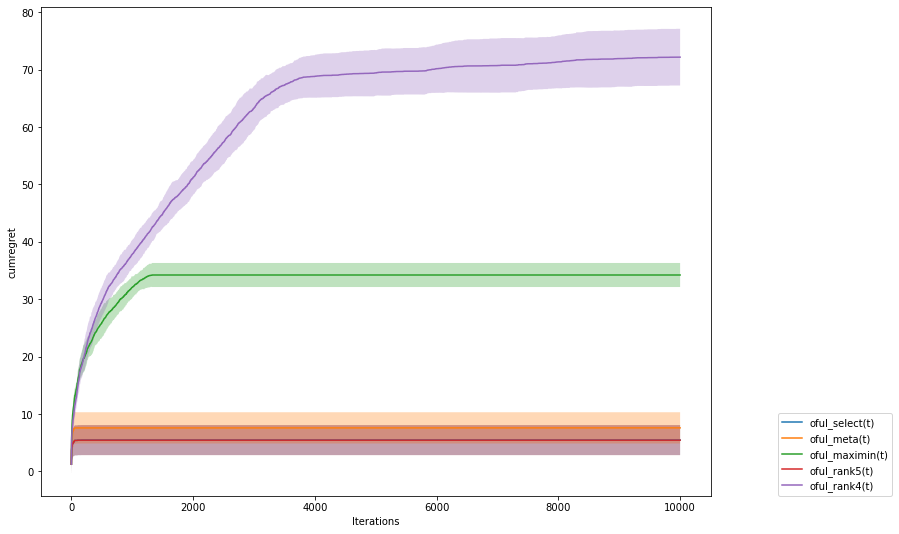

In [14]:
best = ranking[0][0]
nu.compare('../logs', ['oful_select(t)', 'oful_meta(t)', 'oful_maximin(t)', best, ranking[1][0]], 'cumregret', seeds)

Representations selected by model-selection algorithms

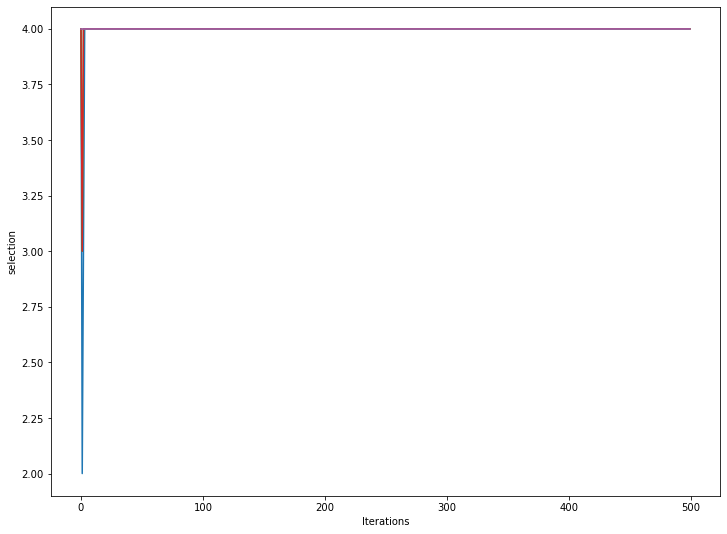

In [15]:
nu.plot_all('../logs', 'oful_select(t)', 'selection', seeds, rows=500)

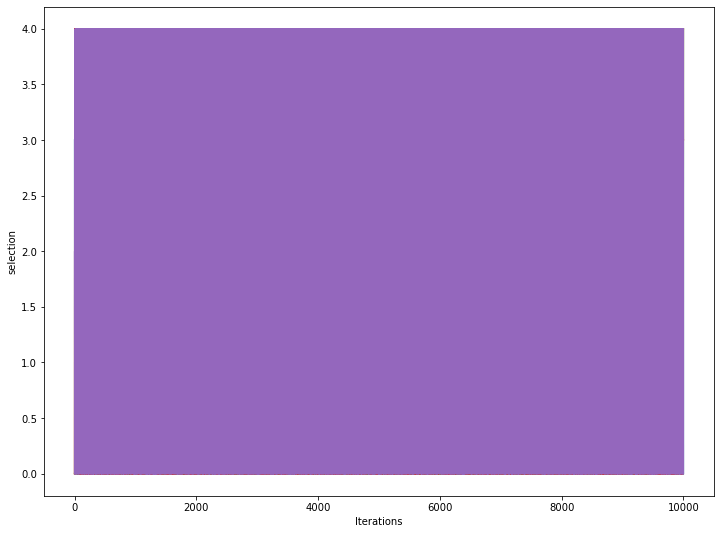

In [16]:
nu.plot_all('../logs', 'oful_meta(t)', 'selection', seeds)

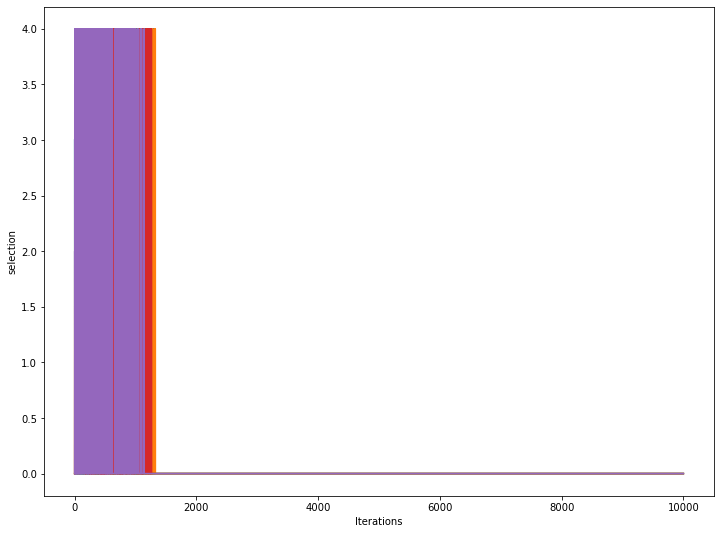

In [17]:
nu.plot_all('../logs', 'oful_maximin(t)', 'selection', seeds)

## CMB, constructive approach (different parameter) (c)

This time I construct a representation of the desired hls rank starting from (the same) reward function

In [28]:
y = r0._rewards

In [29]:
reps = [make_hls_rank(y, dim=dim, rank=i, transform=True, normalize=True) for i in range(1, dim)]

for i, r in enumerate(reps):
    assert np.allclose(r._rewards(), y)  #All representations are equivalent
    assert hls_rank(r) == i+1 #But with different HLS ranks
    assert spans(r) #All representations still span R^d
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.opt_feat_bound(), r.opt_feat_bound(reduce=np.min)))
    
#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

AxisError: axis 1 is out of bounds for array of dimension 0

Regret of OFUL with different representations

In [18]:
params = []
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(c)' % hls_rank(reps[i])
    for seed in seeds:
        params.append(oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name))

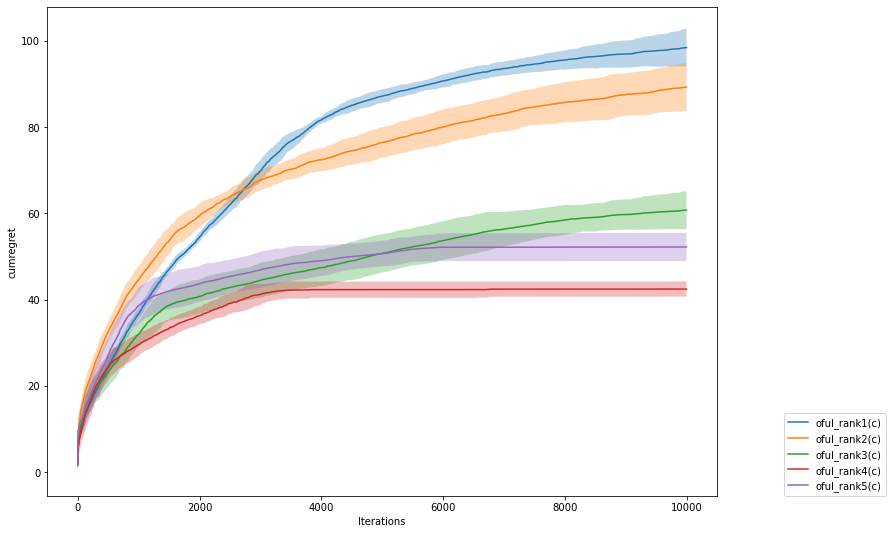

In [19]:
names = ['oful_rank%d(c)' % (i+1) for i in range(dim)] 
nu.compare('../logs', names, 'cumregret', seeds)

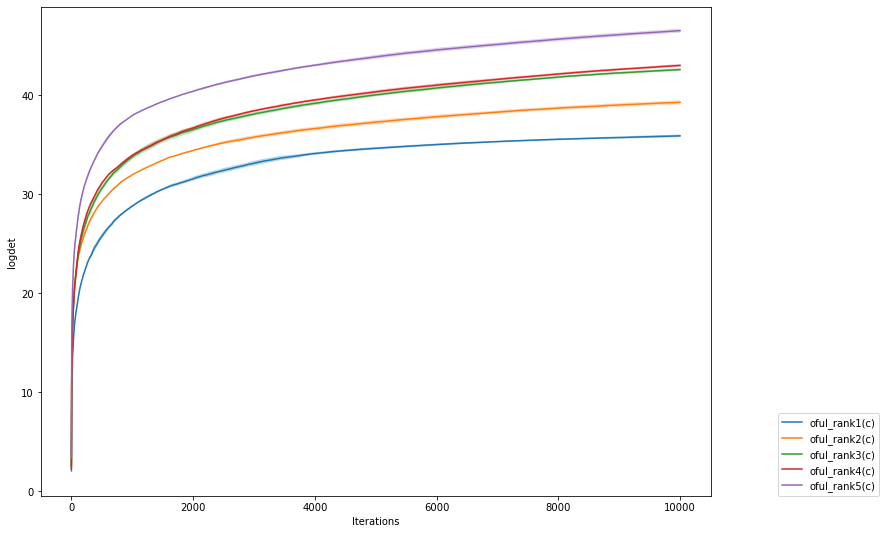

In [20]:
nu.compare('../logs', names, 'logdet', seeds)

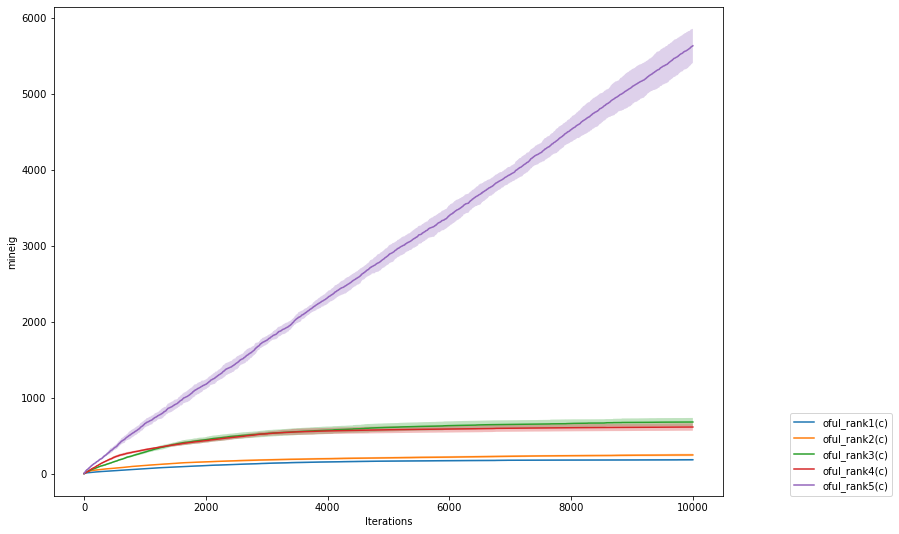

In [21]:
nu.compare('../logs', names, 'mineig', seeds)

(Final) cumulated regret

In [22]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank4(c)', 42.42772922546266),
 ('oful_rank5(c)', 52.18135280425652),
 ('oful_rank3(c)', 60.734236023897395),
 ('oful_rank2(c)', 89.26437353041516),
 ('oful_rank1(c)', 98.43616118159507)]

Regret of model-selection algorithm compared to best model

In [12]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_select(c)')

In [23]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_maximin(c)')

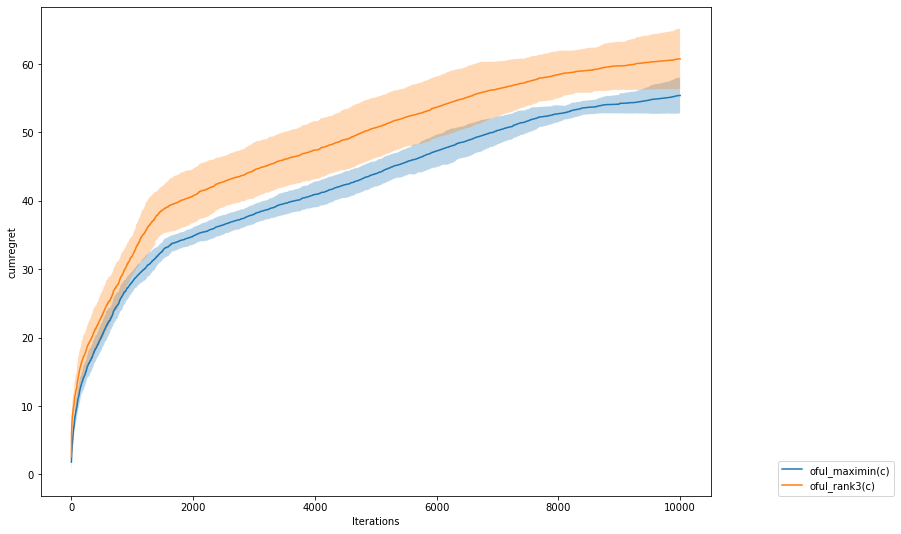

In [25]:
best = ranking[0][0]
nu.compare('../logs', ['oful_maximin(c)', 'oful_rank3(c)'], 'cumregret', seeds)

Representations selected by model-selection algorithm

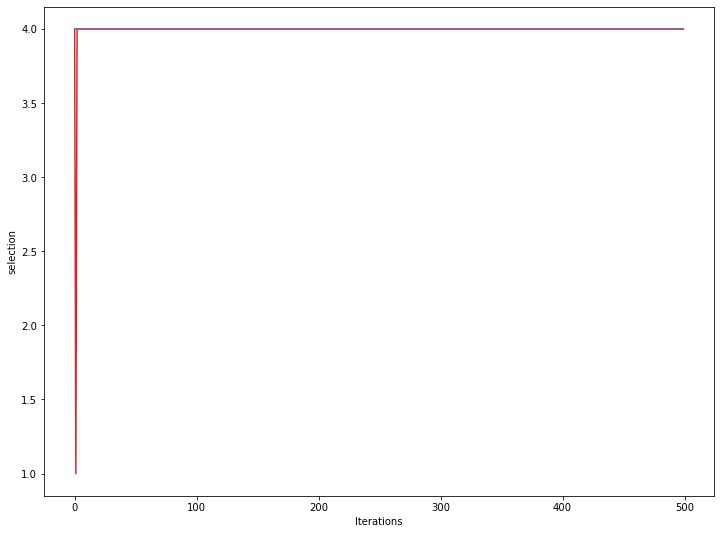

In [28]:
nu.plot_all('../logs', 'oful_select(c)', 'selection', seeds, rows=500)

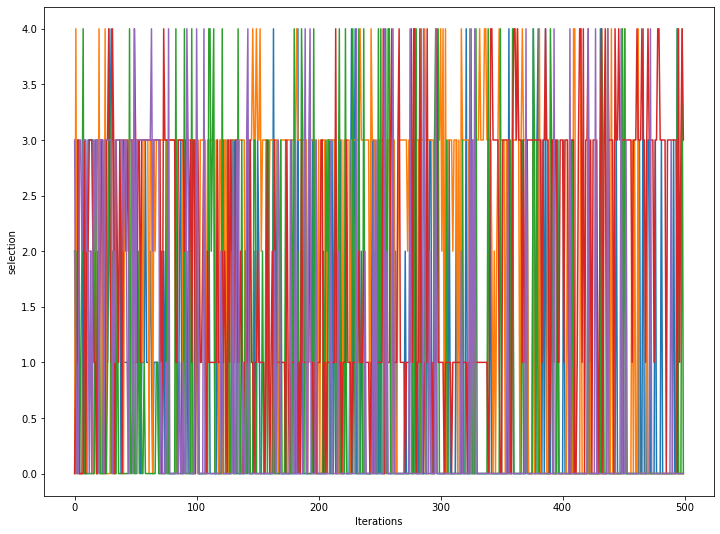

In [29]:
nu.plot_all('../logs', 'oful_maximin(c)', 'selection', seeds, rows=500)

## Why the difference? (different HLS representations)

Original HLS representation

In [30]:
rA = r0

Constructed HLS representation

In [31]:
rB = make_hls_rank(r0._rewards(), dim=dim, rank=dim)

Both are HLS and equivalent

In [32]:
assert rA == rB
assert is_hls(rA)
assert is_hls(rB)

But the performance of OFUL is different

In [33]:
problem = FiniteMultiBandit(nc, na, [rA, rB])

In [34]:
for seed in seeds:
        problem.select_rep(0)
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='ofulA')
        problem.select_rep(1)
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='ofulB')

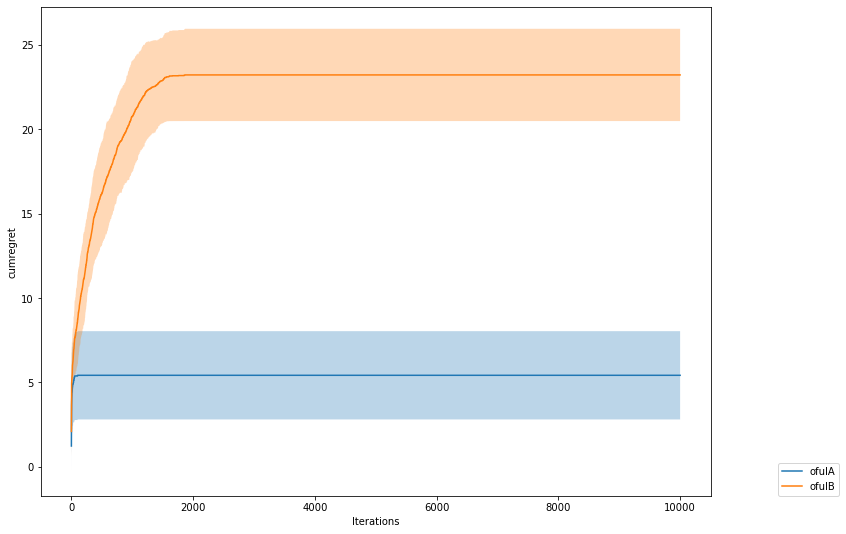

In [35]:
nu.compare('../logs', ['ofulA', 'ofulB'], 'cumregret', seeds)

The reason may be that the minimum eigenvalue of optimal features is different

In [36]:
hls_lambda(rA)

1.0207350383885851

In [37]:
hls_lambda(rB)

0.532267257606073

In [38]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/2, param_bound, seed=seed, verbose=False, logname='oful_selectAB')

In [39]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/2, param_bound, seed=seed, verbose=False, logname='oful_maximinAB')

oful_select is able to select the best representation

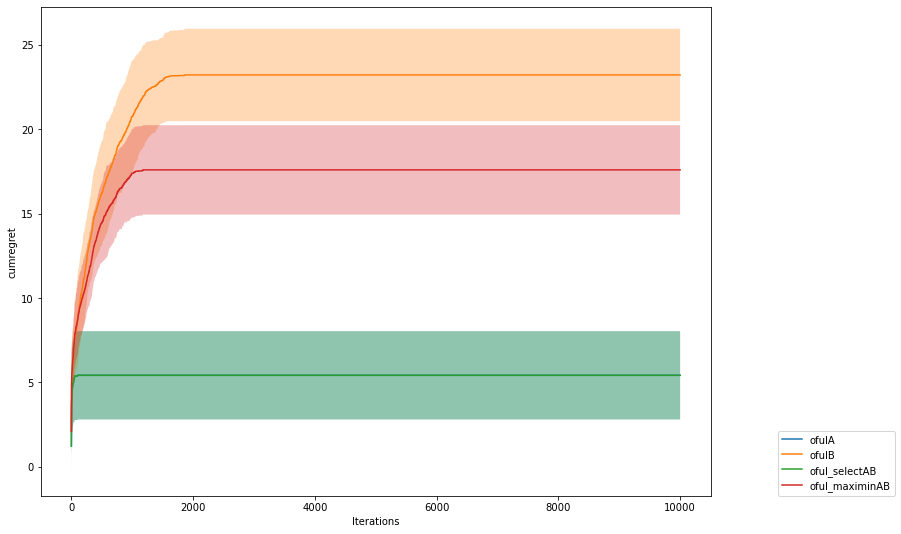

In [40]:
nu.compare('../logs', ['ofulA', 'ofulB', 'oful_selectAB', 'oful_maximinAB'], 'cumregret', seeds)

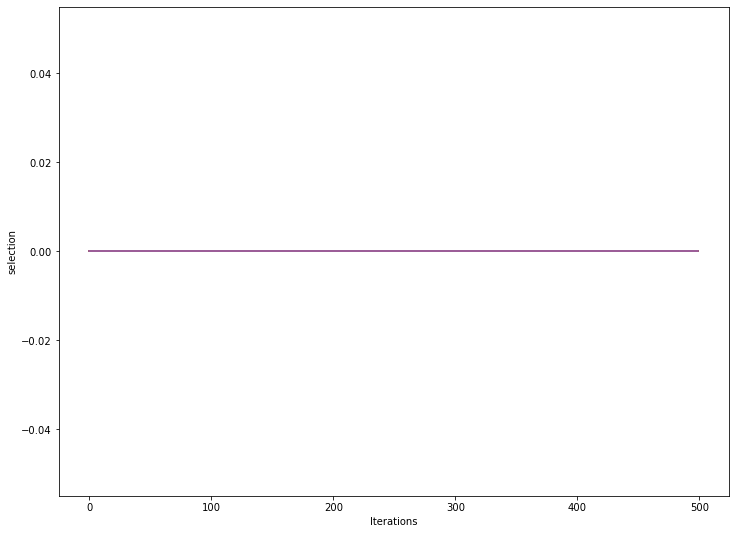

In [41]:
nu.plot_all('../logs', 'oful_selectAB', 'selection', seeds, rows=500)

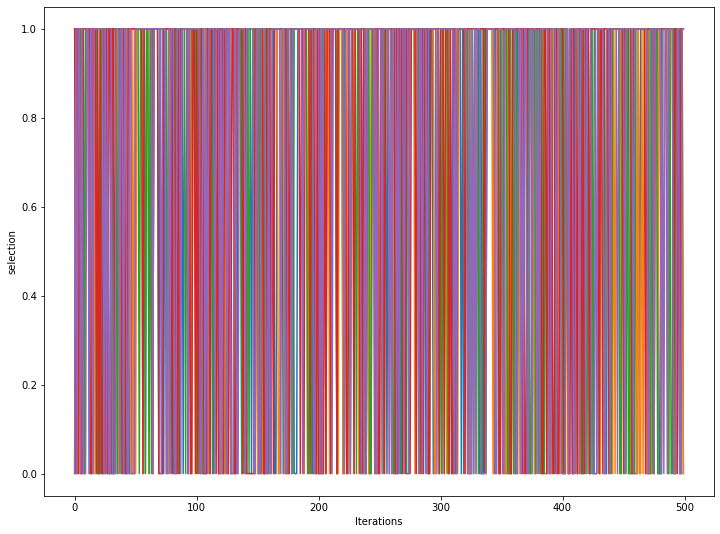

In [42]:
nu.plot_all('../logs', 'oful_maximinAB', 'selection', seeds, rows=500)

## Not CMB (destructive, different param) (n)

I make the original representation NOT CMB while preserving HLS

In [43]:
rr = derank_cmb(r0, save_hls=True)
assert rr == r0
assert is_hls(rr)
assert not is_cmb(rr)

In [44]:
reps = [derank_hls(rr, i, transform=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(rr)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    assert not is_cmb(r) #None of them is CMB
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.feat_bound(), r.opt_feat_bound()))
print('%d/%d %s %f %f' % (hls_rank(reps[-1]), rank(reps[-1]), '(CMB)' if is_cmb(r) else '', reps[-1].feat_bound(), reps[-1].opt_feat_bound()))

#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/5  5.218460 3.490063
2/5  5.218460 3.514993
3/5  5.218460 3.587039
4/5  5.218460 3.556675
5/5  5.637567 5.637567


Regret of OFUL with different representations

In [45]:
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(n)' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

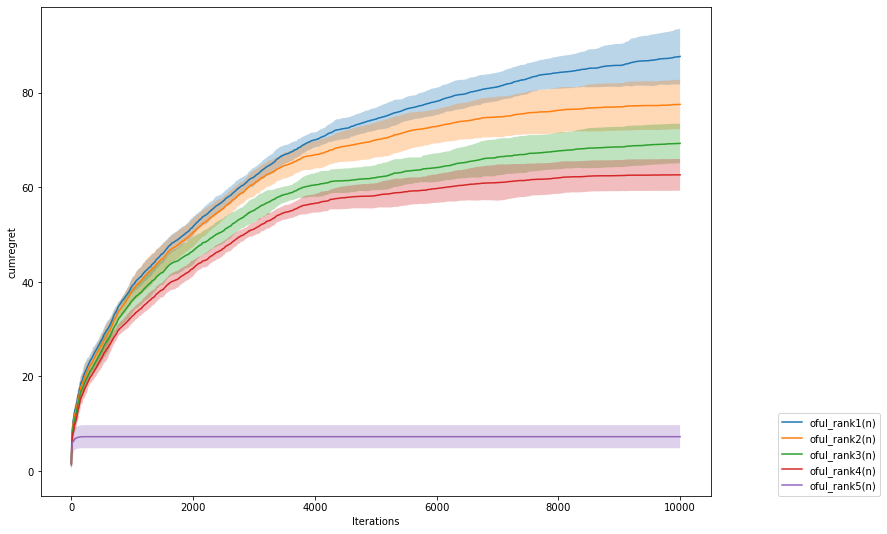

In [46]:
names = ['oful_rank%d(n)' % (i+1) for i in range(dim)]
nu.compare('../logs', names, 'cumregret', seeds)

(Final) cumulated regret is (almost) sorted by hls rank, with the HLS representation having a large advantage

In [47]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank5(n)', 7.270732517292814),
 ('oful_rank4(n)', 62.625598354023715),
 ('oful_rank3(n)', 69.27243416272071),
 ('oful_rank2(n)', 77.51732699209929),
 ('oful_rank1(n)', 87.65978650613819)]

Regret of model-selection algorithm compared to best model

In [48]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_select(n)')

In [49]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_maximin(n)')

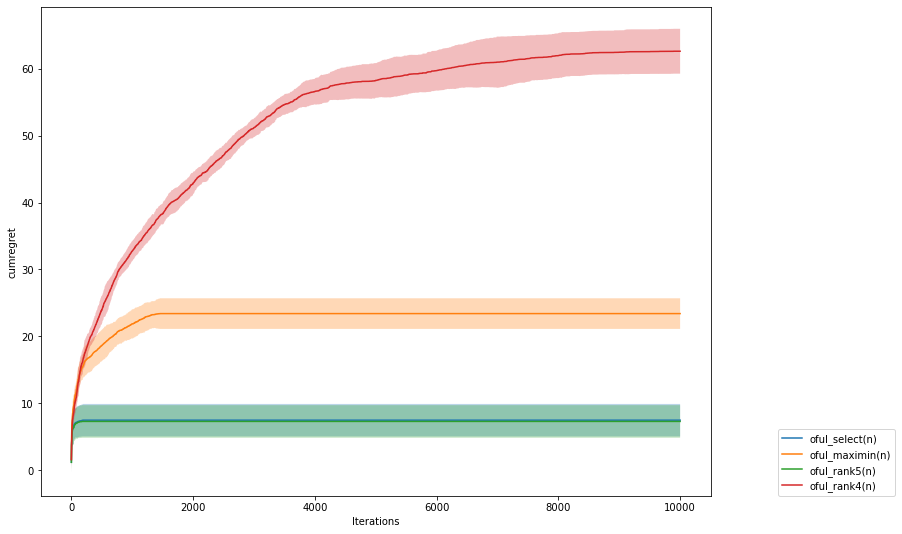

In [50]:
best = ranking[0][0]
nu.compare('../logs', ['oful_select(n)', 'oful_maximin(n)', best, ranking[1][0]], 'cumregret', seeds)

Representations selected by model-selection algorithm

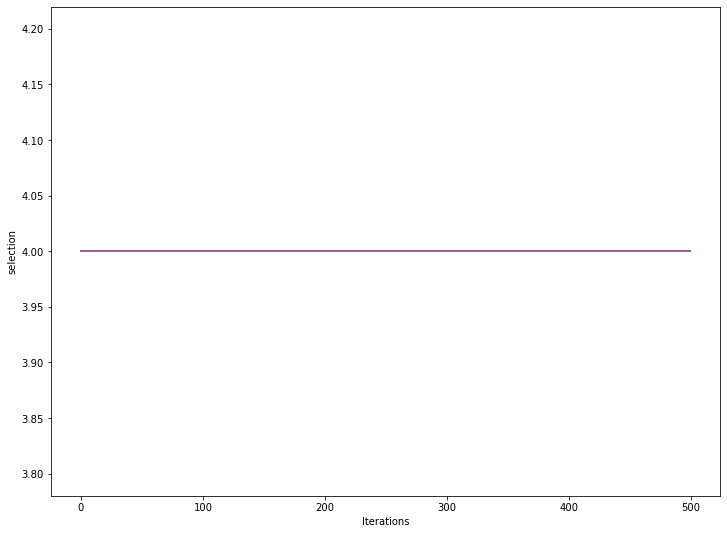

In [51]:
nu.plot_all('../logs', 'oful_select(n)', 'selection', seeds, rows=500)

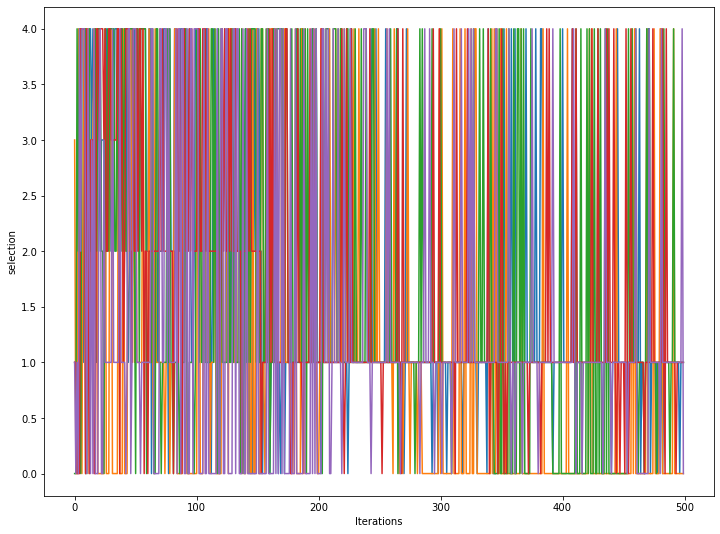

In [52]:
nu.plot_all('../logs', 'oful_maximin(n)', 'selection', seeds, rows=500)